In [3]:
##1. Importing necessary Libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
from sklearn.pipeline import Pipeline
import xgboost as XGBClassifier
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.style.use('ggplot')

In [5]:
## 2. Data Collection

In [6]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
column_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
df = pd.read_csv(url, names=column_names)

In [7]:
print("Dataset Shape:", df.shape)
df.head()

Dataset Shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [8]:
## 3. Exploratory Data Analysis (EDA)

In [11]:
print("Summary Statistics:")
df.describe()

Summary Statistics:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [12]:
print("\nMissing Values:")
df.isnull().sum()


Missing Values:


Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [13]:
print("\nZero Values Count:")
for column in df.columns:
    print(f"{column}: {(df[column] == 0).sum()}")


Zero Values Count:
Pregnancies: 111
Glucose: 5
BloodPressure: 35
SkinThickness: 227
Insulin: 374
BMI: 11
DiabetesPedigreeFunction: 0
Age: 0
Outcome: 500


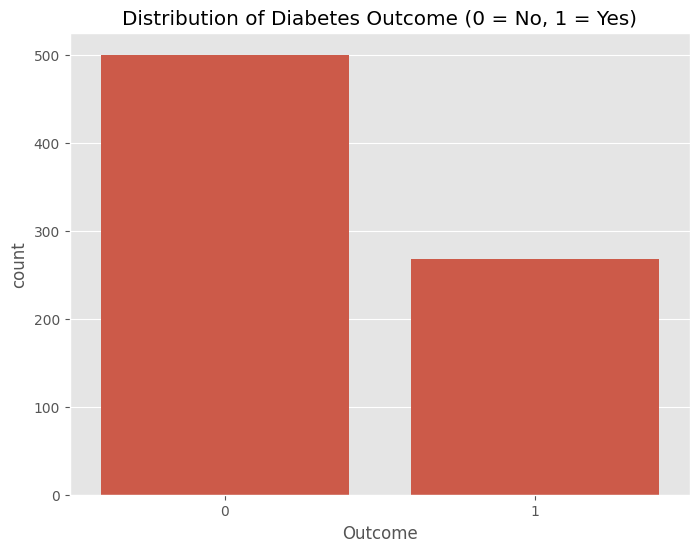

In [14]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Outcome', data=df)
plt.title('Distribution of Diabetes Outcome (0 = No, 1 = Yes)')
plt.show()

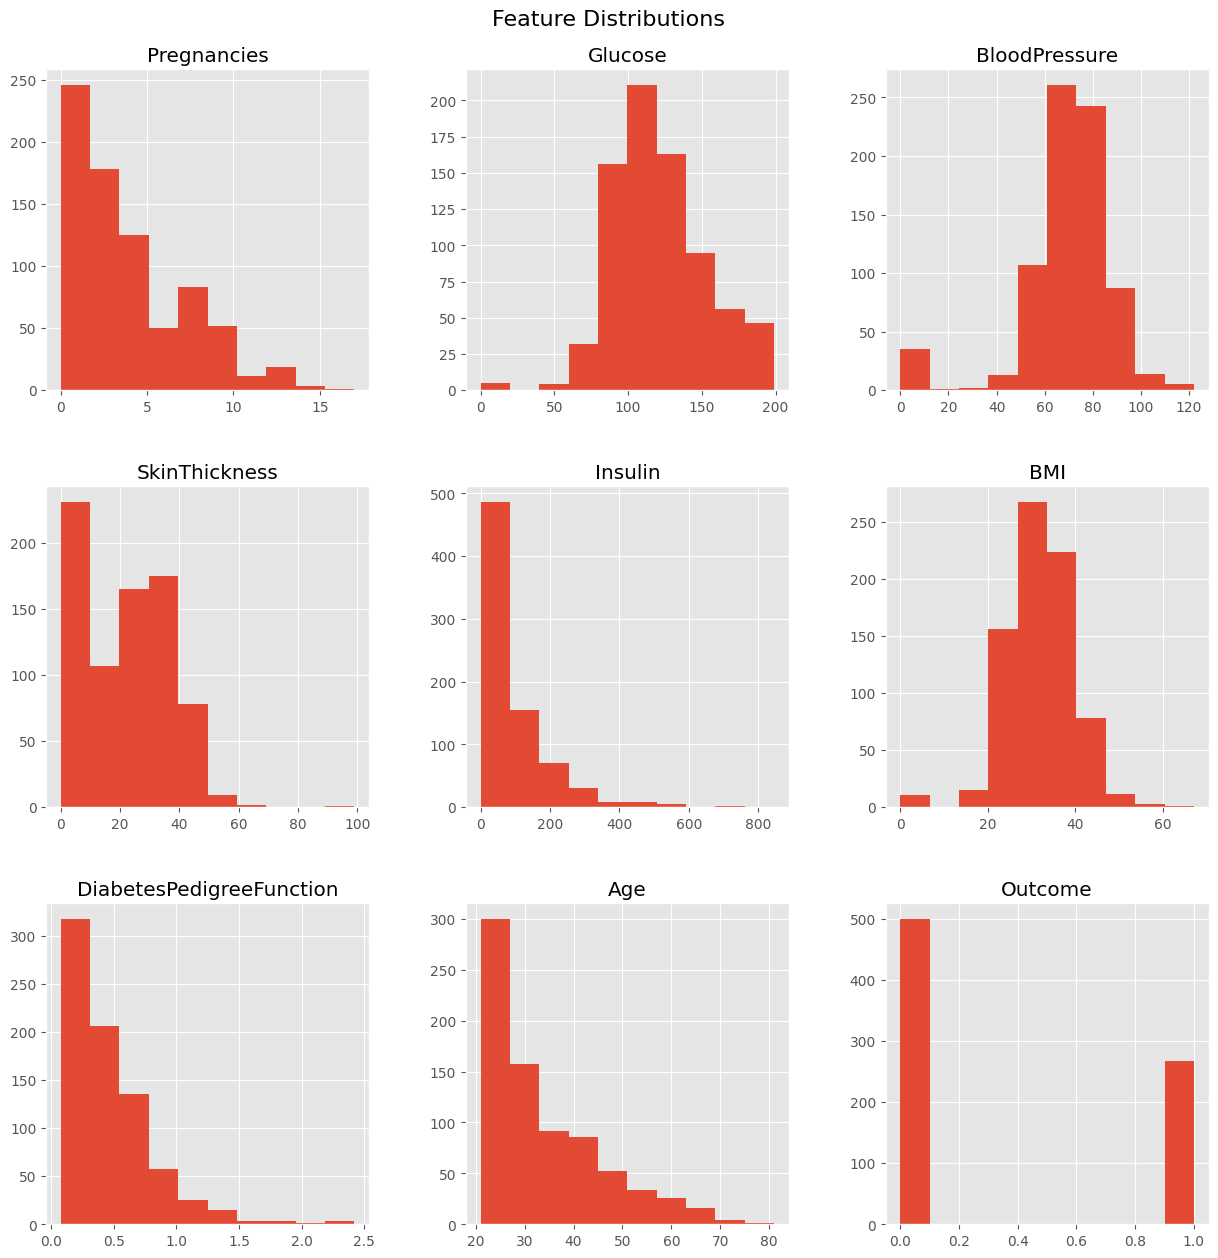

In [15]:
df.hist(figsize=(15, 15))
plt.suptitle("Feature Distributions", y=0.92, fontsize=16)
plt.show()

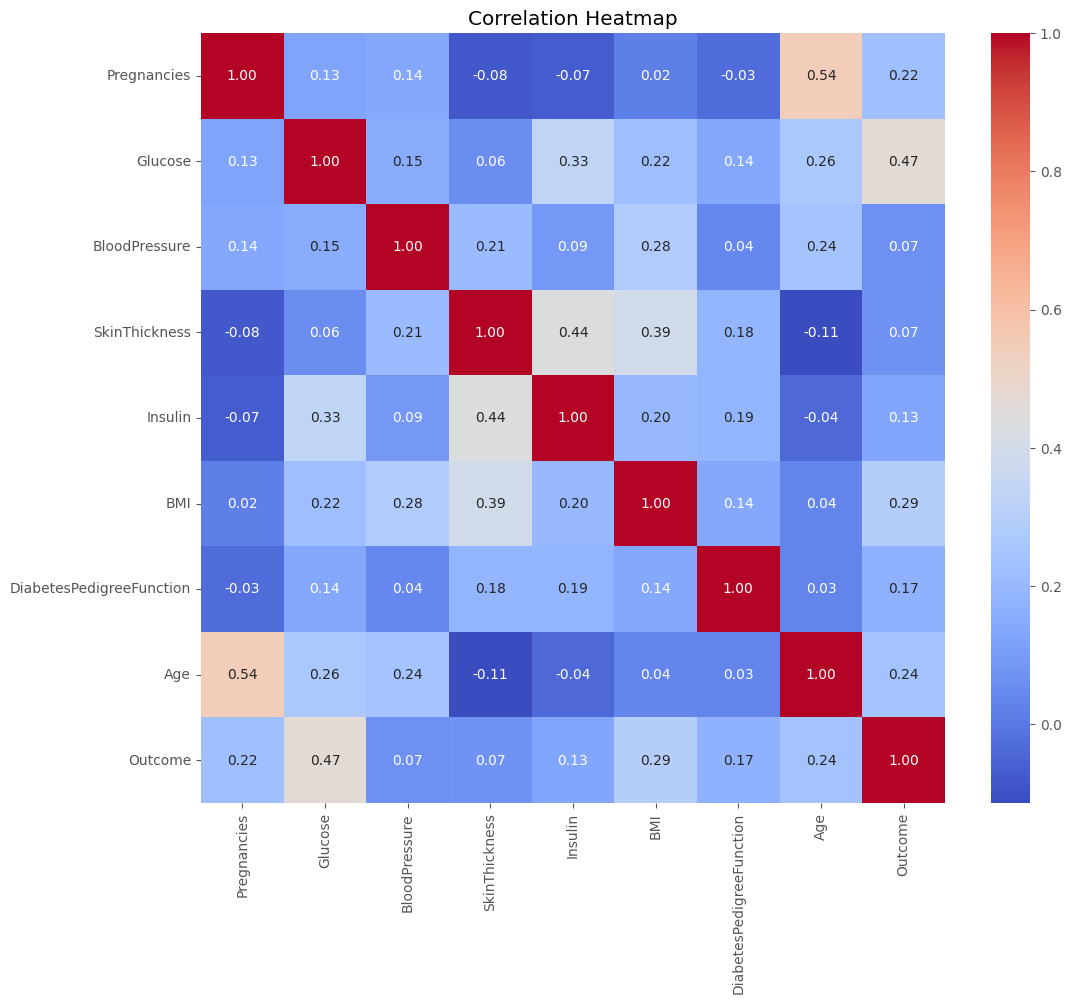

In [16]:
plt.figure(figsize=(12, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

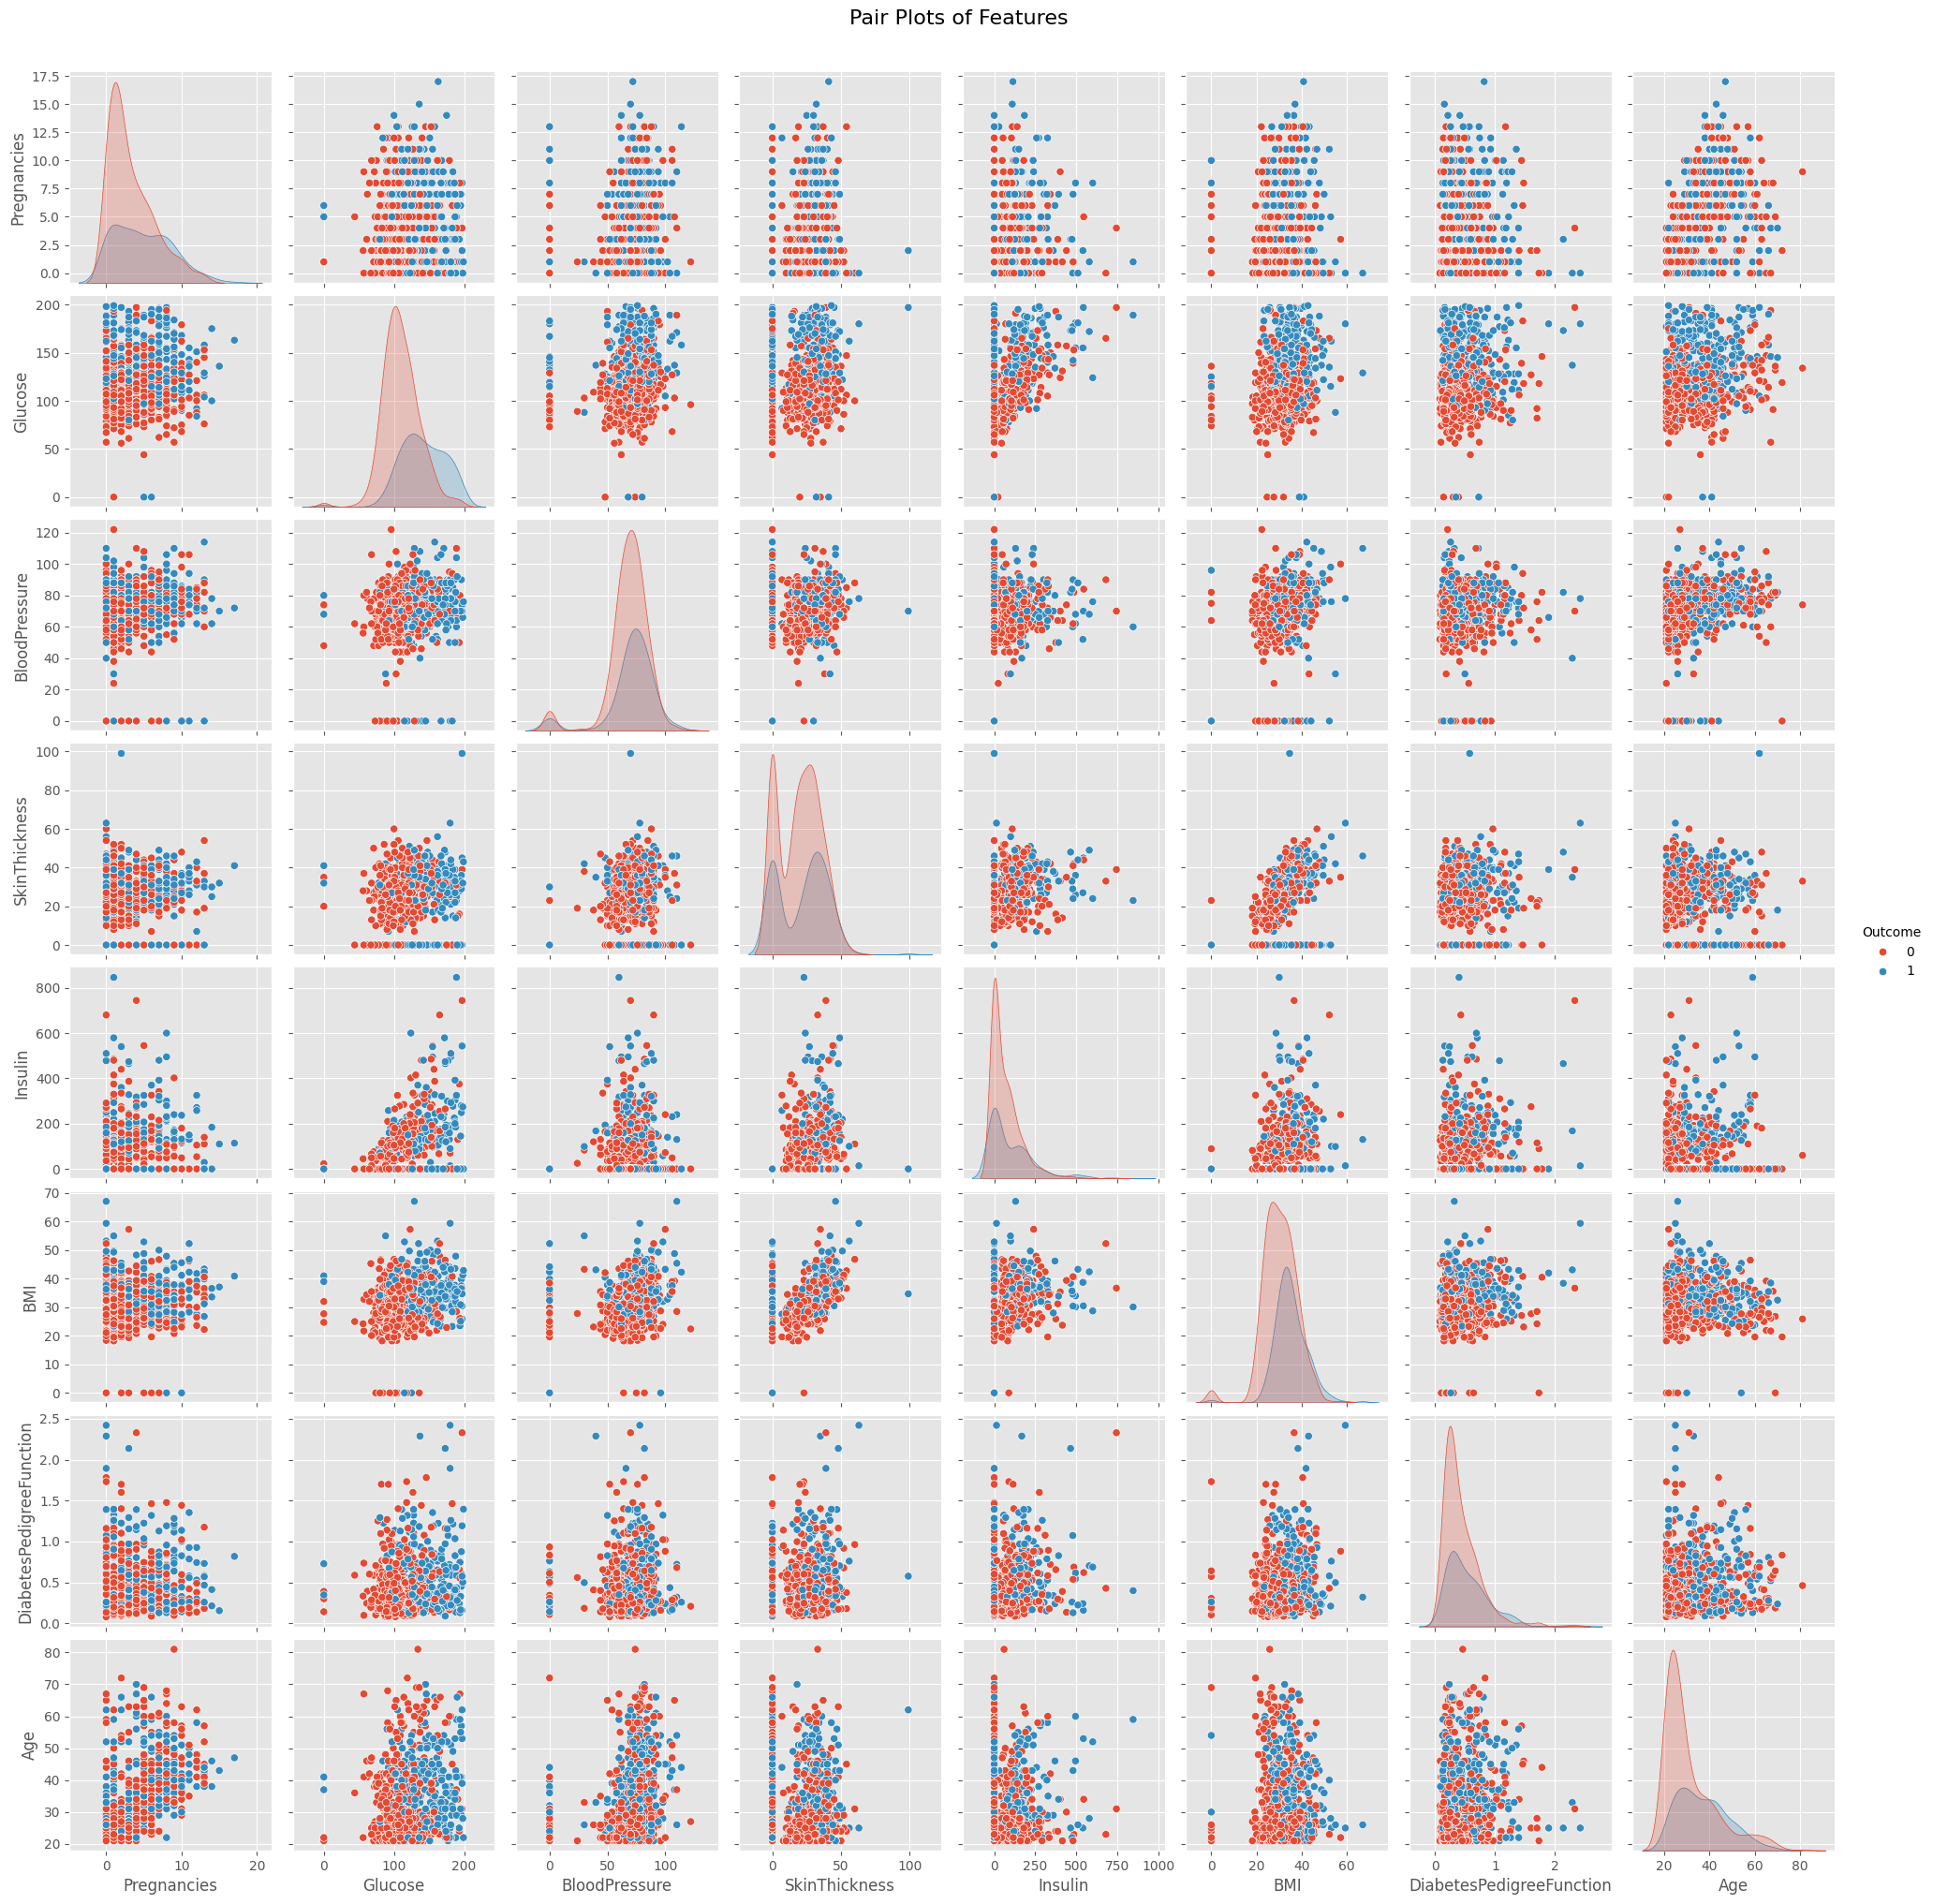

In [17]:
sns.pairplot(df, hue='Outcome', diag_kind='kde', height=2.5)
plt.suptitle("Pair Plots of Features", y=1.02, fontsize=16)
plt.show()

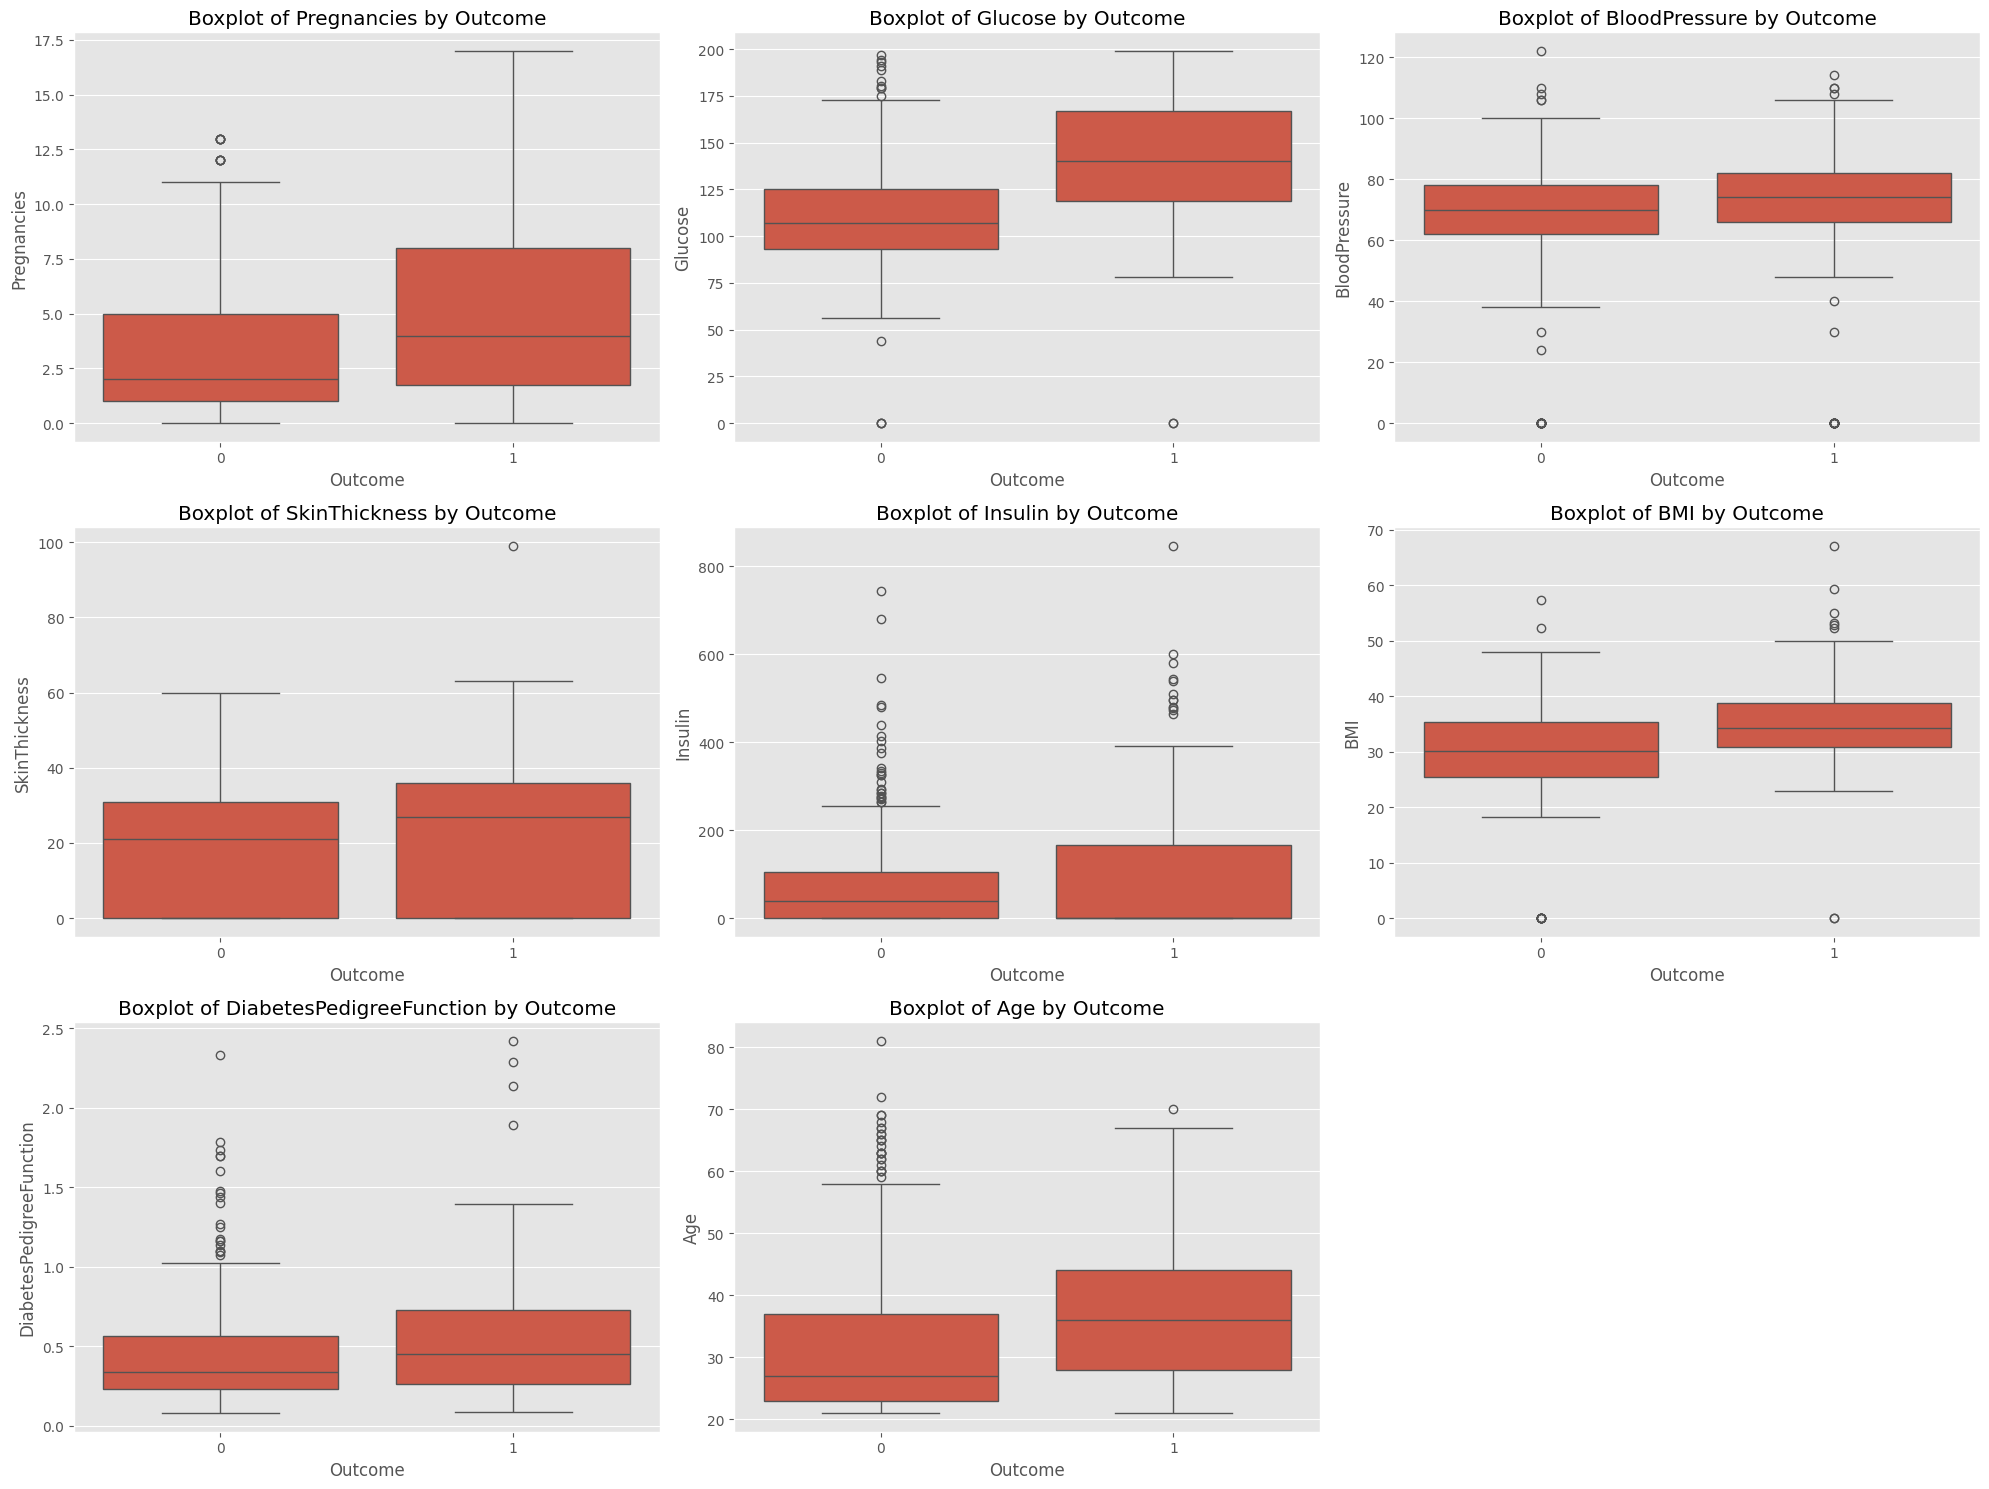

In [18]:
plt.figure(figsize=(20, 15))
for i, column in enumerate(df.columns[:-1], 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x='Outcome', y=column, data=df)
    plt.title(f'Boxplot of {column} by Outcome')
plt.tight_layout()
plt.show()

In [19]:
## 4. Data Preprocessing

In [20]:
zero_not_valid = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for column in zero_not_valid:
    df[column] = df[column].replace(0, np.nan)


for column in df.columns[:-1]:
    df[column].fillna(df[column].median(), inplace=True)


print("Missing values after imputation:")
df.isnull().sum()

Missing values after imputation:


Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [22]:
X = df.drop('Outcome', axis=1)
y = df['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (614, 8)
Testing set shape: (154, 8)


In [23]:
## 5. Model Building and Evaluation

In [35]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    
    # Cross-validation score
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
    
    # Print results
    print(f"\n{model_name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"Cross-Validation ROC AUC: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    
    # Confusion Matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    
    # ROC Curve
    plt.figure(figsize=(8, 6))
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend()
    plt.show()
    
    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    return model, accuracy, precision, recall, f1, roc_auc


Logistic Regression Results:
Accuracy: 0.7078
Precision: 0.6000
Recall: 0.5000
F1 Score: 0.5455
ROC AUC: 0.8130
Cross-Validation ROC AUC: 0.8432 ± 0.0293


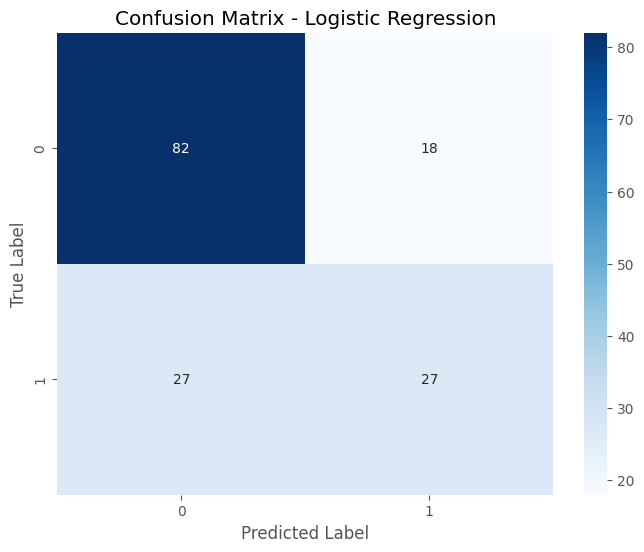

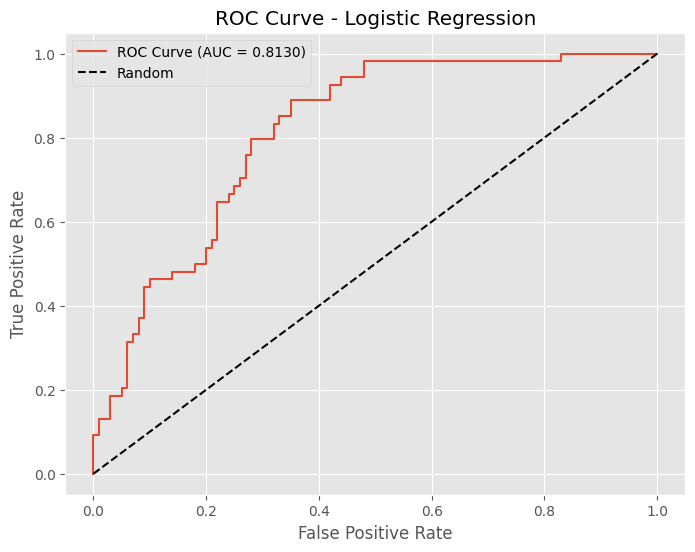


Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.82      0.78       100
           1       0.60      0.50      0.55        54

    accuracy                           0.71       154
   macro avg       0.68      0.66      0.67       154
weighted avg       0.70      0.71      0.70       154



In [39]:
## Logistic Regression

log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg_results = evaluate_model(log_reg, X_train_scaled, X_test_scaled, y_train, y_test, "Logistic Regression")


Decision Tree Results:
Accuracy: 0.6818
Precision: 0.5532
Recall: 0.4815
F1 Score: 0.5149
ROC AUC: 0.6357
Cross-Validation ROC AUC: 0.6644 ± 0.0166


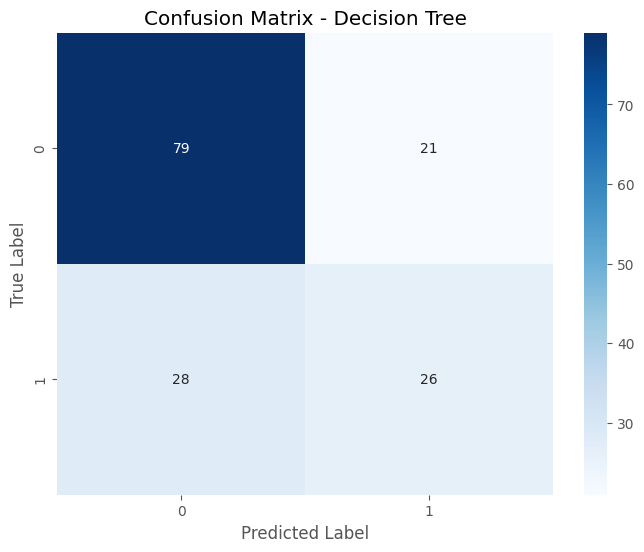

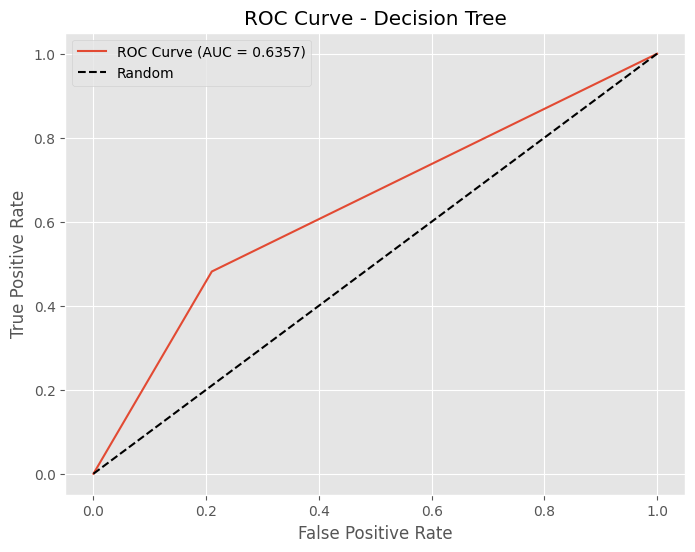


Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.79      0.76       100
           1       0.55      0.48      0.51        54

    accuracy                           0.68       154
   macro avg       0.65      0.64      0.64       154
weighted avg       0.67      0.68      0.68       154



In [40]:
## Decision Trees

dt = DecisionTreeClassifier(random_state=42)
dt_results = evaluate_model(dt, X_train_scaled, X_test_scaled, y_train, y_test, "Decision Tree")


Random Forest Results:
Accuracy: 0.7792
Precision: 0.7174
Recall: 0.6111
F1 Score: 0.6600
ROC AUC: 0.8179
Cross-Validation ROC AUC: 0.8248 ± 0.0226


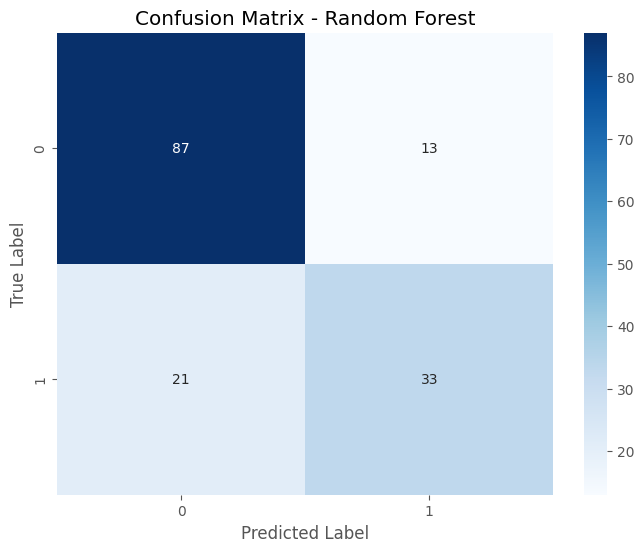

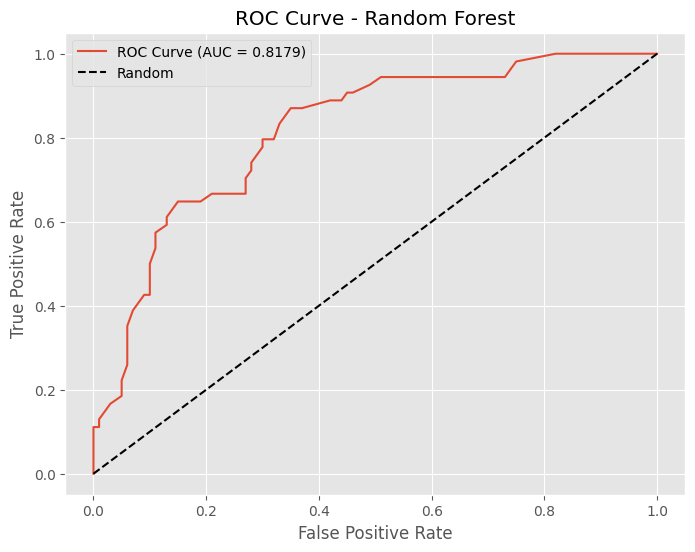


Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       100
           1       0.72      0.61      0.66        54

    accuracy                           0.78       154
   macro avg       0.76      0.74      0.75       154
weighted avg       0.77      0.78      0.77       154



In [41]:
## Random Forest

rf = RandomForestClassifier(random_state=42)
rf_results = evaluate_model(rf, X_train_scaled, X_test_scaled, y_train, y_test, "Random Forest")



XGBoost Results:
Accuracy: 0.7597
Precision: 0.6735
Recall: 0.6111
F1 Score: 0.6408
ROC AUC: 0.8081
Cross-Validation ROC AUC: 0.7832 ± 0.0303


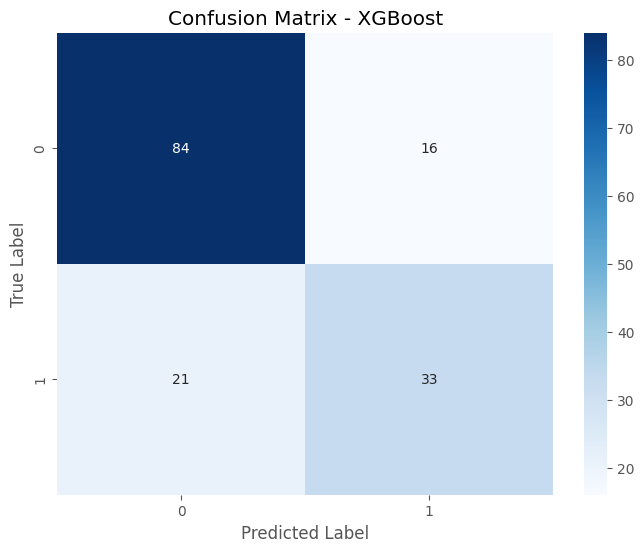

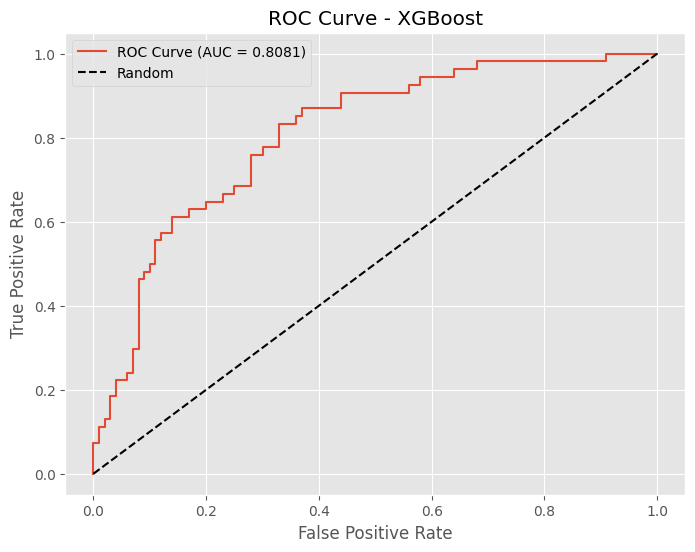


Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       100
           1       0.67      0.61      0.64        54

    accuracy                           0.76       154
   macro avg       0.74      0.73      0.73       154
weighted avg       0.76      0.76      0.76       154



In [43]:
## XGBoost

from xgboost import XGBClassifier
xgb = XGBClassifier(random_state=42)
xgb_results = evaluate_model(xgb, X_train_scaled, X_test_scaled, y_train, y_test, "XGBoost")

In [44]:
## 6. Hyperparameter Tuning for Best Model

In [45]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best ROC AUC score:", grid_search.best_score_)

Best parameters: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Best ROC AUC score: 0.8398145071982281



Tuned Random Forest Results:
Accuracy: 0.7468
Precision: 0.6744
Recall: 0.5370
F1 Score: 0.5979
ROC AUC: 0.8063
Cross-Validation ROC AUC: 0.8398 ± 0.0182


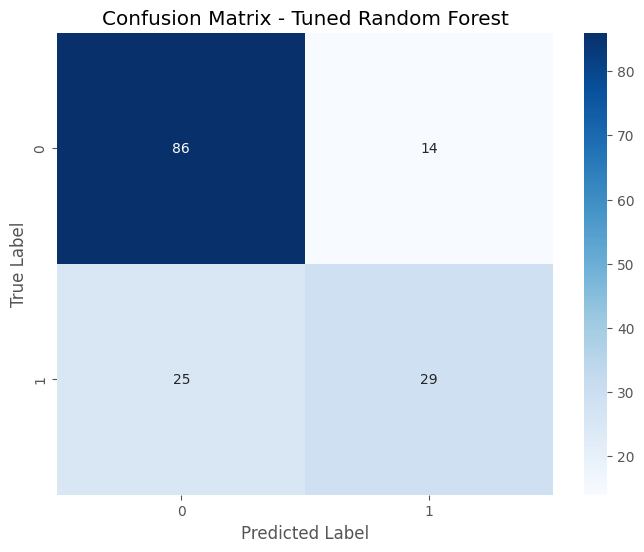

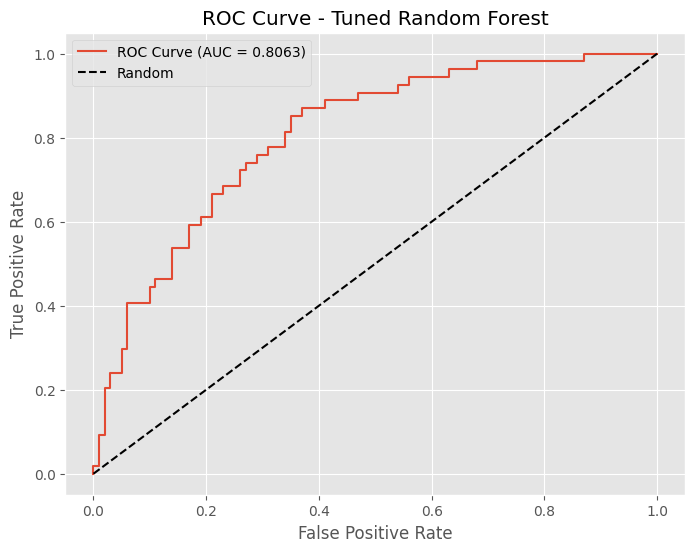


Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.86      0.82       100
           1       0.67      0.54      0.60        54

    accuracy                           0.75       154
   macro avg       0.72      0.70      0.71       154
weighted avg       0.74      0.75      0.74       154



In [46]:
best_rf = grid_search.best_estimator_
best_rf_results = evaluate_model(best_rf, X_train_scaled, X_test_scaled, y_train, y_test, "Tuned Random Forest")

In [47]:
## 7. Feature Importance Analysis

In [48]:
def plot_feature_importance(model, feature_names, model_name):
    if hasattr(model, 'feature_importances_'):
        # For tree-based models
        importances = model.feature_importances_
    else:
        # For linear models (if using Logistic Regression)
        importances = np.abs(model.coef_[0])
    
    # Create DataFrame with feature names and importance scores
    feature_imp = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feature_imp = feature_imp.sort_values(by='Importance', ascending=False)
    
    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_imp)
    plt.title(f'Feature Importance - {model_name}')
    plt.tight_layout()
    plt.show()
    
    return feature_imp

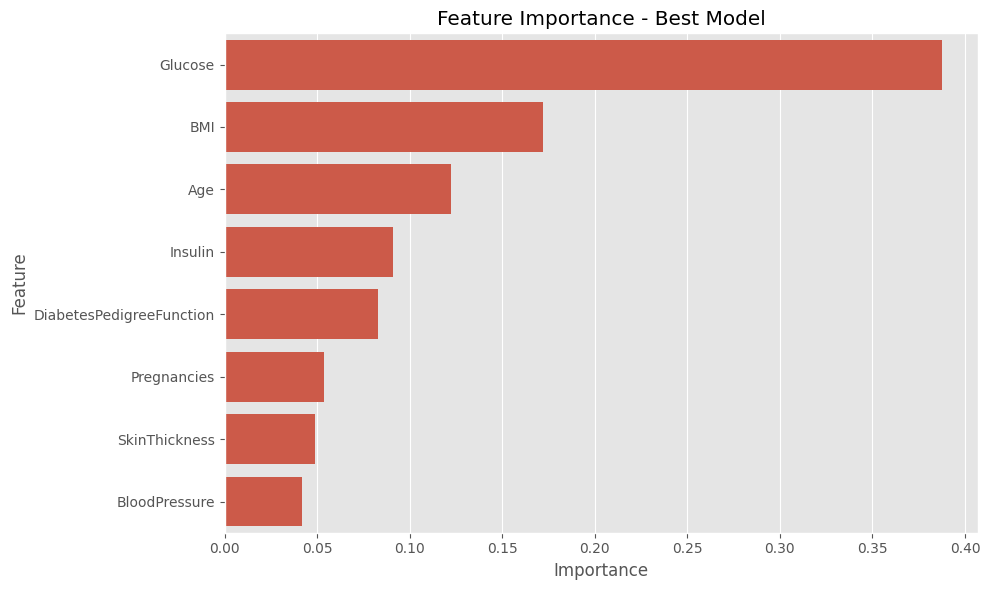

Feature Importance Ranking:
                    Feature  Importance
1                   Glucose    0.387435
5                       BMI    0.172036
7                       Age    0.122565
4                   Insulin    0.091184
6  DiabetesPedigreeFunction    0.082664
0               Pregnancies    0.053918
3             SkinThickness    0.048616
2             BloodPressure    0.041584


In [49]:
best_model_importances = plot_feature_importance(best_rf, X.columns, "Best Model")
print("Feature Importance Ranking:")
print(best_model_importances)

In [50]:
## 8. Model Comparison

In [51]:
models = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost', 'Tuned Random Forest']
accuracies = [log_reg_results[1], dt_results[1], rf_results[1], xgb_results[1], best_rf_results[1]]
precisions = [log_reg_results[2], dt_results[2], rf_results[2], xgb_results[2], best_rf_results[2]]
recalls = [log_reg_results[3], dt_results[3], rf_results[3], xgb_results[3], best_rf_results[3]]
f1_scores = [log_reg_results[4], dt_results[4], rf_results[4], xgb_results[4], best_rf_results[4]]
roc_aucs = [log_reg_results[5], dt_results[5], rf_results[5], xgb_results[5], best_rf_results[5]]

In [52]:
comparison_df = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracies,
    'Precision': precisions,
    'Recall': recalls,
    'F1 Score': f1_scores,
    'ROC AUC': roc_aucs
})

In [53]:
comparison_df = comparison_df.sort_values(by='ROC AUC', ascending=False).reset_index(drop=True)

print("Model Comparison:")
print(comparison_df)

Model Comparison:
                 Model  Accuracy  Precision    Recall  F1 Score   ROC AUC
0        Random Forest  0.779221   0.717391  0.611111  0.660000  0.817870
1  Logistic Regression  0.707792   0.600000  0.500000  0.545455  0.812963
2              XGBoost  0.759740   0.673469  0.611111  0.640777  0.808148
3  Tuned Random Forest  0.746753   0.674419  0.537037  0.597938  0.806296
4        Decision Tree  0.681818   0.553191  0.481481  0.514851  0.635741


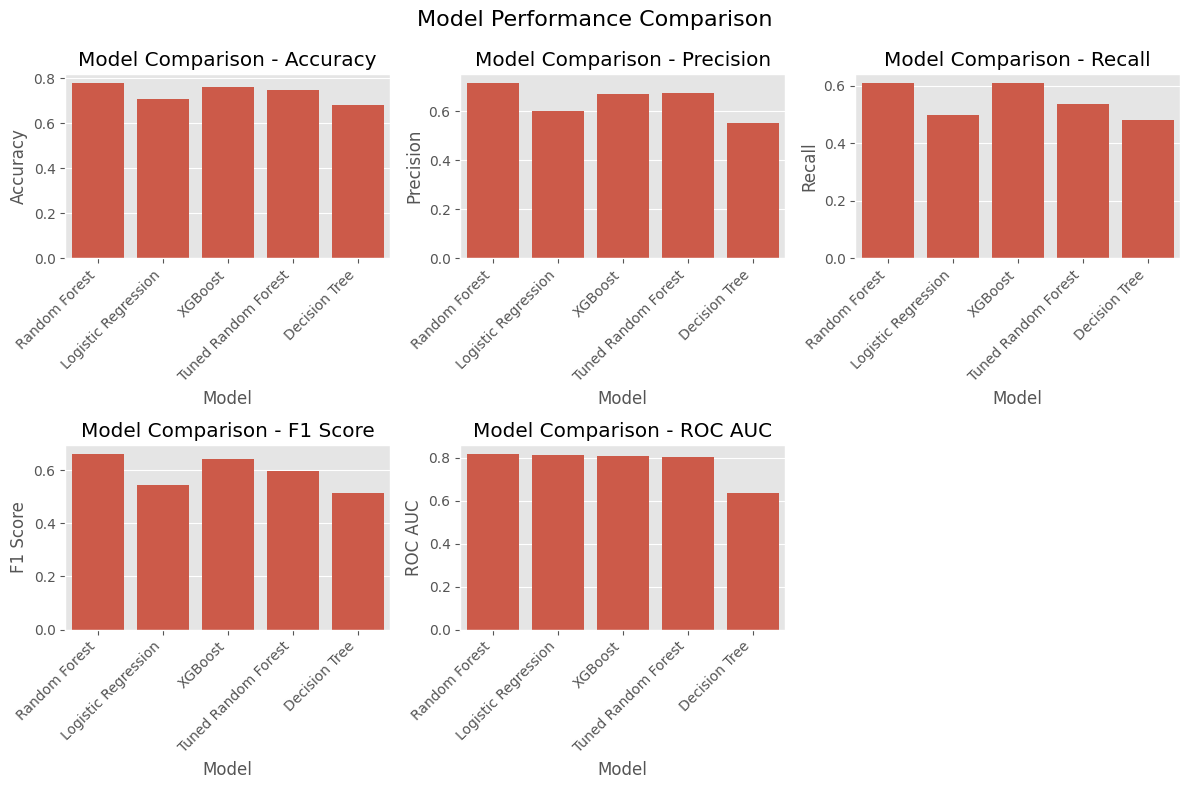

In [55]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']

plt.figure(figsize=(12, 8))
for i, metric in enumerate(metrics):
    plt.subplot(2, 3, i+1)
    sns.barplot(x='Model', y=metric, data=comparison_df)
    plt.xticks(rotation=45, ha='right')
    plt.title(f'Model Comparison - {metric}')
    plt.tight_layout()
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle('Model Performance Comparison', fontsize=16)
plt.subplots_adjust(top=0.9)
plt.show()

In [56]:
## 9. Save the Best Model

In [57]:
import joblib

# Save the scaler and model
joblib.dump(scaler, 'diabetes_scaler.pkl')
joblib.dump(best_rf, 'diabetes_prediction_model.pkl')

print("Scaler and model have been saved.")


Scaler and model have been saved.


In [59]:
## 10. Simple Prediction Function for New Data

In [60]:
def predict_diabetes(model, scaler, patient_data):
    """
    Make a diabetes prediction for new patient data.
    
    Parameters:
    - model: Trained model
    - scaler: Fitted standard scaler
    - patient_data: DataFrame with patient information (same features as training data)
    
    Returns:
    - prediction: 0 (No Diabetes) or 1 (Diabetes)
    - probability: Probability of having diabetes
    """
    # Ensure the data has the correct features
    required_features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 
                         'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
    
    # Check if all required features are present
    if not all(feature in patient_data.columns for feature in required_features):
        missing = [f for f in required_features if f not in patient_data.columns]
        raise ValueError(f"Missing features: {missing}")
    
    # Scale the features
    patient_data_scaled = scaler.transform(patient_data)
    
    # Make prediction
    prediction = model.predict(patient_data_scaled)[0]
    probability = model.predict_proba(patient_data_scaled)[0, 1]
    
    return prediction, probability

In [61]:
# Example of using the prediction function


sample_patient = pd.DataFrame({
    'Pregnancies': [2],
    'Glucose': [130],
    'BloodPressure': [70],
    'SkinThickness': [30],
    'Insulin': [150],
    'BMI': [28.5],
    'DiabetesPedigreeFunction': [0.5],
    'Age': [45]
})

prediction, probability = predict_diabetes(best_rf, scaler, sample_patient)
print(f"Diabetes Prediction: {'Yes' if prediction == 1 else 'No'}")
print(f"Probability of having diabetes: {probability:.4f}")

Diabetes Prediction: No
Probability of having diabetes: 0.4371
